Source:
https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c

Dataset:
https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles?select=train.csv

In [1]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
import pandas as pd

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d blessondensil294/topic-modeling-for-research-articles -p /content
!unzip -q topic-modeling-for-research-articles.zip -d /content/dataset

 44% 5.00M/11.4M [00:00<00:00, 29.0MB/s]
100% 11.4M/11.4M [00:00<00:00, 58.5MB/s]


In [4]:
train_data = pd.read_csv('/content/dataset/train.csv')
train_data.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
train_data.shape

(20972, 9)

In [6]:
x=train_data.iloc[:,3:].sum()
rowsums=train_data.iloc[:,2:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of articles = ",len(train_data))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


<ipython-input-6-fb69382689c0>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsums=train_data.iloc[:,2:].sum(axis=1)


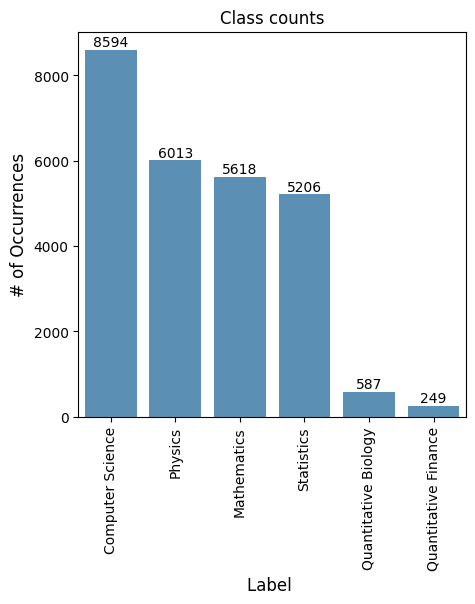

In [9]:
x=train_data.iloc[:,3:].sum()
plt.figure(figsize=(5,5))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8, )
plt.title("Class counts")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label ', fontsize=12)
plt.xticks(rotation=90)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [10]:
train_data['Text'] = train_data['TITLE']+' '+train_data['ABSTRACT']
train_data = train_data.drop(columns=['TITLE','ABSTRACT', 'ID'])
train_data.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Text
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,0,0,1,0,0,0,A finite element approximation for the stochas...
4,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [ ]:
# Text preprocessing
#Remove Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    return text

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_data['Text'] = train_data['Text'].apply(lambda x: remove_stopwords(x))
train_data['Text'] = train_data['Text'].apply(lambda x:clean_text(x))
train_data['Text'] = train_data['Text'].apply(stemming)

In [12]:
X = train_data['Text']
y = train_data.drop(['Text'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# Vectorization (embedding)
tfidfvector = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidfvector.fit_transform(X_train)
X_test_tfidf = tfidfvector.transform(X_test)

In [2]:
#multi-label version of kNN is represented by MLkNN

#from skmultilearn.adapt import MLkNN
#classifier = MLkNN(k=6)
#classifier.fit(X_train_tfidf, y_train)
#predictions = classifier.predict(X_test_tfidf)
#accuracy_score(y_test,predictions)

In [15]:
cls1 = BinaryRelevance(LogisticRegression(solver='sag'))
cls1.fit(X_train_tfidf, y_train)
pred1 = cls1.predict(X_test_tfidf)

print('Accuracy = ', accuracy_score(y_test, pred1))
print('F1 score is ',f1_score(y_test, pred1, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, pred1))

Accuracy =  0.6543504171632897
F1 score is  0.8061389337641356
Hamming Loss is  0.07628128724672228


In [ ]:
cls2 = ClassifierChain(LogisticRegression(solver='sag'))
cls2.fit(X_train_tfidf, y_train)
pred2 = cls2.predict(X_test_tfidf)

print('Accuracy = ', accuracy_score(y_test, pred2))
print('F1 score is ',f1_score(y_test, pred2, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, pred2))

Accuracy =  0.6698450536352801
F1 score is  0.8019295136837961
Hamming Loss is  0.07993643226062773


In [ ]:
cls3 = LabelPowerset(LogisticRegression(solver='sag'))
cls3.fit(X_train_tfidf, y_train)
pred3 = cls3.predict(X_test_tfidf)

print('Accuracy = ', accuracy_score(y_test, pred3))
print('F1 score is ',f1_score(y_test, pred3, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, pred3))

Accuracy =  0.6758045292014303
F1 score is  0.8059583703265266
Hamming Loss is  0.07814858959078268


In [ ]:
# Nueral network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Convert target labels to NumPy arrays
import numpy as np
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Define the MLP model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              5121024   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 5127174 (19.56 MB)
Trainable params: 5127174 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

In [ ]:
# Train the model
history = model.fit(X_train_tfidf_dense, y_train, callbacks=[monitor], epochs=30, batch_size=64, validation_data=(X_test_tfidf_dense, y_test))

Epoch 1/30
263/263 [==============================] - 3s 7ms/step - loss: 0.2566 - accuracy: 0.7325 - val_loss: 0.1796 - val_accuracy: 0.7576
Epoch 2/30
263/263 [==============================] - 1s 5ms/step - loss: 0.1503 - accuracy: 0.7900 - val_loss: 0.1731 - val_accuracy: 0.7631
Epoch 3/30
263/263 [==============================] - 1s 5ms/step - loss: 0.1197 - accuracy: 0.8120 - val_loss: 0.1826 - val_accuracy: 0.7676
Epoch 4/30
263/263 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.8302 - val_loss: 0.1940 - val_accuracy: 0.7459
Epoch 5/30
263/263 [==============================] - 2s 7ms/step - loss: 0.0754 - accuracy: 0.8463 - val_loss: 0.2104 - val_accuracy: 0.7452
Epoch 6/30
263/263 [==============================] - 1s 5ms/step - loss: 0.0562 - accuracy: 0.8580 - val_loss: 0.2297 - val_accuracy: 0.7485
Epoch 7/30
263/263 [==============================] - 1s 5ms/step - loss: 0.0391 - accuracy: 0.8673 - val_loss: 0.2528 - val_accuracy: 0.7409
Epoch 

In [ ]:
# Predictions on the validation set
y_pred = model.predict(X_test_tfidf_dense)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model using appropriate multi-label classification metrics
accuracy = accuracy_score(y_test, y_pred_binary)
hamming_loss_value = hamming_loss(y_test, y_pred_binary)
f1_micro = f1_score(y_test, y_pred_binary, average='micro')  # Micro-averaged F1-score

print(f"Accuracy: {accuracy:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F1 Micro: {f1_micro:.2f}")

132/132 [==============================] - 0s 2ms/step
Accuracy: 0.68
Hamming Loss: 0.07
F1 Micro: 0.83
